In [1]:
from torch_snippets_local import inspect_shape, simple_show
import numpy as np
import torch
import torch.nn as nn
import requests
from PIL import Image
url = 'https://lionsvalley.co.za/wp-content/uploads/2015/11/african-elephant-square.jpg'
original_image = Image.open(requests.get(url, stream=True).raw).convert('RGB')
original_image = np.array(original_image)
original_image = torch.Tensor(original_image)

In [2]:
image_net_classes = 'https://gist.githubusercontent.com/yrevar/942d3a0ac09ec9e5eb3a/raw/238f720ff059c1f82f368259d1ca4ffa5dd8f9f5/imagenet1000_clsidx_to_labels.txt'
image_net_classes = requests.get(image_net_classes).text
image_net_ids = eval(image_net_classes)
image_net_classes = {i:j for j,i in image_net_ids.items()}

In [3]:
from torchvision.models import resnet50
model = resnet50(weights='DEFAULT')
for param in model.parameters():
    param.requires_grad = False
model = model.eval()

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /Users/leonjye/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:13<00:00, 7.84MB/s]


In [4]:
from torchvision import transforms as T
from torch.nn import functional as F
normalize = T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
denormalize = T.Normalize([-0.485/0.229, -0.456/0.224, -0.406/0.225], [1/0.229, 1/0.224, 1/0.225])
def image2tensor(input):
    x = normalize(input.clone().permute(2,0,1)/255.)[None]
    return x
def tensor2image(input):
    x = (denormalize(input[0].clone()).permute(1,2,0)*255.).type(torch.uint8)
    return x

In [5]:
def predict_on_image(input):
    model.eval()
    simple_show(input)
    input = image2tensor(input)
    pred = model(input)
    pred = F.softmax(pred, dim=-1)[0]
    prob, clss = torch.max(pred, 0)
    clss = image_net_ids[clss.item()]
    print(f'PREDICTION: `{clss}` @ {prob.item()}')

In [6]:
from tqdm import trange
losses = []
def attack(image, model, target, epsilon=1e-6):
    input = image2tensor(image)
    input.requires_grad = True
    pred = model(input)
    loss = nn.CrossEntropyLoss()(pred, target)
    loss.backward()
    losses.append(loss.mean().item())
    output = input - epsilon * input.grad.sign()
    output = tensor2image(output)
    del input
    return output.detach()

In [7]:
modified_images = []
desired_targets = ['lemon', 'comic book', 'sax, saxophone']

In [8]:
for target in desired_targets:
    target = torch.tensor([image_net_classes[target]])
    image_to_attack = original_image.clone()
    for _ in trange(10):
        image_to_attack = attack(image_to_attack, model, target)
    modified_images.append(image_to_attack)


100%|██████████| 10/10 [00:00<00:00, 19.02it/s]


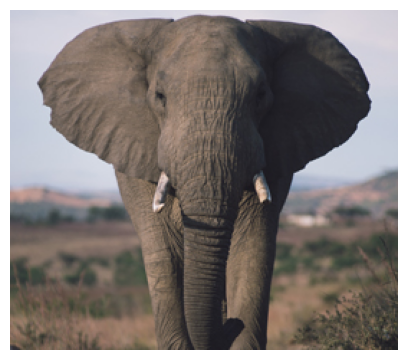

PREDICTION: `tusker` @ 0.1350916475057602
Tensor	Shape: torch.Size([237, 270, 3])	Min: 17.000	Max: 255.000	Mean: 110.237	dtype: torch.float32 @ cpu


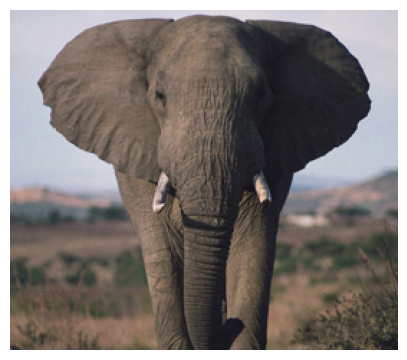

PREDICTION: `lemon` @ 0.9529399871826172
Tensor	Shape: torch.Size([237, 270, 3])	Min: 13.000	Max: 249.000	Mean: 105.236	dtype: torch.uint8 @ cpu


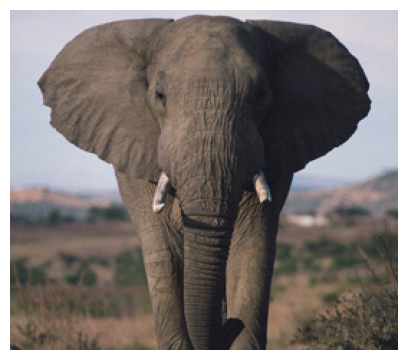

PREDICTION: `comic book` @ 0.9482795596122742
Tensor	Shape: torch.Size([237, 270, 3])	Min: 14.000	Max: 251.000	Mean: 105.240	dtype: torch.uint8 @ cpu


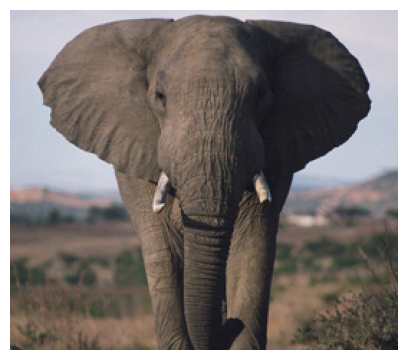

PREDICTION: `sax, saxophone` @ 0.9314069747924805
Tensor	Shape: torch.Size([237, 270, 3])	Min: 12.000	Max: 251.000	Mean: 105.234	dtype: torch.uint8 @ cpu


In [9]:
for image in [original_image, *modified_images]:
    predict_on_image(image)
    inspect_shape(image)